In [1]:
import os
import librosa
import numpy as np
from tensorflow.keras.utils import to_categorical
from scipy.stats import skew

# Function to extract features from an audio file (you may need to adjust it based on your feature extraction method)
def extract_features(file_path):
    y, sr = librosa.load(file_path)

    # Extract Mel-Frequency Cepstral Coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Extract Chroma feature
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Extract Spectral Contrast feature
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # Concatenate the features
    features = np.vstack([mfccs, chroma, contrast])

    return features

# Function to create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

# Directory path where your dataset is located
dataset_path = '../data/audio'

# Initialize lists to store data and labels
data = []
labels = []

# Parameters
sequence_length = 50  # Adjust as needed
num_classes = len(os.listdir(dataset_path))

# Iterate through each class folder
for class_index, class_folder in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_folder)

    # Iterate through each audio file in the class folder
    for audio_file in os.listdir(class_path):
        audio_path = os.path.join(class_path, audio_file)

        # Extract features from the audio file
        features = extract_features(audio_path)

        # Create sequences from the features
        sequences = create_sequences(features.T, sequence_length)

        # Append sequences and corresponding label to the lists
        data.extend(sequences)
        labels.extend([class_index] * len(sequences))

# Convert to numpy arrays
data = np.array(data)
labels = to_categorical(labels, num_classes=num_classes)

# Shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]



c:\Users\burjo\miniconda3\envs\speech\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Build an LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(units=25, input_shape=(X_train.shape[1]//2, X_train.shape[2]//2), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=labels.shape[1], activation='softmax'))


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Reduce learning rate if the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Save the trained model
model.save('../app/models/lstm_model.h5')


ValueError: Input 0 of layer "lstm_7" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)

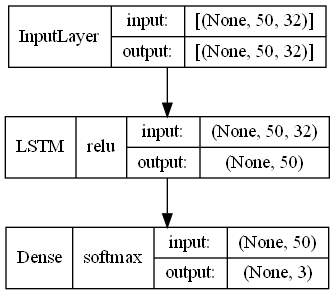

In [3]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)